# 3D Plotting in Python for Hurricane Data

## Visualizations of Hurricane Harvey Pre-Landfall in 3D and 2D using ERA5 Data

#### Created by Quinton Lawton, University of Miami Rosenstiel School of Marine and Atmospheric Science (RSMAS)

*While I provide this as an open source resource and encourage others to adapt this to their own purposes, please do not pass this particular jupyter notebook, embedded scripts, data, or resulting figures off as your own.* 

**If you found this to be useful for your own work, I would greatly appreciate an awknowledgment!**

Last updated: 3/26/2020

#### Import Statements
Import a number of important python packages for use in this code. If this script errors or states that it "cannot be found/loaded", you likely need to install the package before running this module. **Important modules include:**
- *NetCDF4* -- to load in nc data
- *Cartopy* -- mapping/background toolkit
- *Numpy* -- so python can handle matrices/arrays
- *Plotly* -- our 3D visualization package

In [1]:
# IMPORT STATEMENTS AND RELATED TASKS
import time
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy.ndimage import gaussian_filter
    #import scitools.numpytools as N
from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime

import numpy.ma as ma

import plotly.graph_objects as go

import metpy.calc as mpcalc
from metpy.plots import StationPlot
from metpy.units import units
from mpl_toolkits import mplot3d

#### Directories and System Settings
Sets relatively directories, defines the resolution of the data we are importing, and finally the system information (for the best track data for Harvey downloaded from NHC). Other things are loaded in as well. 

This can be changed based on the dataset you are intersted in, but make sure you change the netcdf4 file so that there is at least a few timesteps of overlap between it and the best track data -- otherwise, there will be a plethora of errors!

In [2]:
#DIRECTORIES
resolution = 0.25
era5_dir = '../ERA5/3D/'
filt_dir = '../ERA5/FILTERED/'
track_dir = '../TRACKS/'

#SYSTEM INFORMATION
year ='2017'
system = '09'
resolution = 0.25

#PROJECTION SETTINGS
dataproj = ccrs.PlateCarree()

#BOX EXTENT
box_dim = 3 #degrees latitude
box_num = box_dim/resolution

#### Import External Functions
We will use some of these function later.*There is a lot of data manipulation contained in these important functions, and it can sometimes get a bit hairy.* I recommend looking under the hood if you want to better understand how this is done and any errors/misplots that could result with data other than ERA5. 

In [3]:
from invest_data_tools import pull_bt_invest, invest_hourly_interp, circle2, convert_lon_standard, round_res, track_to_index
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(idx)
    return idx, array[idx]

In [4]:
def track_to_index_extra(bt_time, nctime):
    import datetime
    from netCDF4 import Dataset, num2date, date2num
    units = 'hours since 1900-01-01 00:00:00.0' #define units
    
    #----- CONVERT BEST TRACK DATA TO PYTHON TIME -----
    bdate_list = []
    for i in bt_time:
        bdate = datetime.datetime.strptime(i, "%Y%m%d%H")
        #convert date to number corresponding to correct hour
        bdate_num = date2num(bdate, units, calendar = 'gregorian')
        bdate_list.append(bdate_num)
    bdate_list = [round(x) for x in bdate_list]
    #print(bdate_list)
    
    #Find repeated times in Best Track data to get rid of them
    Repeat_Times = [idx for idx, item in enumerate(bdate_list) if item in bdate_list[:idx]]
    date_list_string = list(map(str, bdate_list))
    nctime_string = list(map(str, nctime))
    storm_dates = [i for i, x in enumerate(nctime_string) if any(thing in x for thing in date_list_string)]

    nctime_dates = [i for i, x in enumerate(date_list_string) if any(thing in x for thing in nctime_string)]
    
    #
    nctime_dates_final = [i for i in nctime_dates if i not in Repeat_Times]
    
    
    start_date= storm_dates[0]
    end_date = storm_dates[-1]
    
    #print('\nstarting and ending index for the features we are interested in:')
    #print([start_date, end_date])
    return storm_dates, nctime_dates_final

In [5]:
def invest_hourly_interp_extra(lon_list, lat_list, time_in):
    import numpy as np
    import datetime
    '''Take invest data and linearily interpolate positions to be hourly, allowing use with hourly reanalysis data.'''
    
    #Determine the timestep of the inputted datelist
    dt_list = []
    dt_list_hr = []
    for tm in time_in:
        dt_list.append(datetime.datetime.strptime(tm, '%Y%m%d%H'))
    
    #Now, what's the time difference between each invest timestep?
    
    elapsedTime = dt_list[2]-dt_list[1]
    hourDelta = elapsedTime.seconds/3600 #We divide by 3600 to get the timedelta in hours
    
    #Interpolate the given lon_list data
    totalElapsed = dt_list[-1] - dt_list[0] #Determine the time elapsed from the very beginning of the dataset to the end
    totalElapsed = totalElapsed.total_seconds()/3600 #Converted to hours
    #print(hourDelta)
    
    origX = np.arange(0, totalElapsed+1, hourDelta) #Original hour list: w add one to get arange to consider endpoint
    newX = np.arange(0, totalElapsed+1, 1) #New hour list, for 1 per hour
    #print(len(origX), len(lon_list))
    
    #Now, interpolate data points
    lon_list_hr = np.interp(newX, origX, lon_list)
    lat_list_hr = np.interp(newX, origX, lat_list)
    
    #Next, create new datatime array
    def daterange(start_date, end_date):
        delta = timedelta(hours=1)
        while start_date <= end_date:
            yield start_date
            start_date += delta
            
    from datetime import datetime, timedelta

    start_date = dt_list[0]
    end_date = dt_list[-1]
    for single_date in daterange(start_date, end_date):
        dt_list_hr.append(single_date.strftime("%Y%m%d%H"))
    
    return lon_list_hr, lat_list_hr, dt_list_hr  

#### Pull Best Track Data for our Storm of Interest (Harvey)
We will also clean up this data -- in the called function, we already removed duplicate hours but will do it one more time in case something slipped through. We also remove non-6 hourly data, so that we can smoothly interpolate.

In [6]:
bt_time_raw, bt_lat_raw, bt_lon_raw, bt_name = pull_bt_invest(track_dir, year, system, name_in='HARVEY_POSTGEN')
HourlyTimes = [0,6,12,18,24]


#But, there are lots of duplicate times so we need to remove them, and remove anything not in 6-hourly timesteps
Hour_List = [datetime.datetime.strptime(bt_time_raw[i], "%Y%m%d%H").hour for i,x in enumerate(bt_time_raw)]

Repeat_Times = [idx for idx, item in enumerate(bt_time_raw) if item in bt_time_raw[:idx]]
OutofRange = [idx for idx, item in enumerate(Hour_List) if item not in HourlyTimes]

#Get our new, final arrays
bt_time = [x for i, x in enumerate(bt_time_raw) if i not in Repeat_Times and i not in OutofRange]
bt_lat = [x for i, x in enumerate(bt_lat_raw) if i not in Repeat_Times and i not in OutofRange]
bt_lon = [x for i, x in enumerate(bt_lon_raw) if i not in Repeat_Times and i not in OutofRange]

#print(len(bt_time))

#### Pull NETCDF4 Data -- ERA5 Pressure Levels
We are just pulling out our data from netCDF files and doing some early manipuation on our **pressure level data**.

In [7]:
#Pull the file name of our data
filename_3d = era5_dir+ 'harvey_3D_extra_variables_aug_25_26.nc'
nc_3D = Dataset(filename_3d, 'r')

#Pull out coordinate
nctime = nc_3D.variables['time'][:]
nctime_units = nc_3D.variables['time'].units
nclat = nc_3D.variables['latitude'][:]
nclon = nc_3D.variables['longitude'][:]

#Convert from 0 to 360 longitudes to -180 to 180 longitudes (for compatability and display later on)
nclon = convert_lon_standard(nclon)

#Find, slice out only the area we are interested in (to reduce file size and prevent memory overuse/dumps!)
lon_st, n = find_nearest(nclon, -110)
lon_end, n = find_nearest(nclon, -30)
lat_st, n = find_nearest(nclat, 40)
lat_end, n = find_nearest(nclat, 0)
nclat = nclat[lat_st:lat_end]
nclon = nclon[lon_st:lon_end]

# Pull out specific humidity, u, and v components of the wind on all pressure levels
q = nc_3D.variables['q'][:,:,lat_st:lat_end,lon_st:lon_end]
u = nc_3D.variables['u'][:,:,lat_st:lat_end,lon_st:lon_end]
v = nc_3D.variables['v'][:,:,lat_st:lat_end,lon_st:lon_end]

#Calculate absolute wind speed
wind_speed = np.sqrt(u**2+v**2)

#Pull out pressure levels so we can find out where we are plotting data!
levels = nc_3D.variables['level'][:]
# rv_cont = np.arange(5e-5,5e-4,4e-5)
# vo_thres = rv_cont[1]
# print(vo_data)
#nc_3D.close()

#### Pull NETCDF4 Data -- ERA5 Single Levels
We are just pulling out our data from netCDF files and doing some early manipuation on our **single level data**.

In [8]:
filename_single = era5_dir+ 'harvey_single_level_3D.nc'
nc_single = Dataset(filename_single, 'r')
nctime_sl = nc_single.variables['time']
new_lat = nc_single.variables['latitude'][:]
new_lon = nc_single.variables['longitude'][:]
print(new_lon)
#new_lon = convert_lon_standard(new_lon)
new_lat 
new_lon

lon_st, n = find_nearest(new_lon, -110)
lon_end, n = find_nearest(new_lon, -30)
lat_st, n = find_nearest(new_lat, 40)
lat_end, n = find_nearest(new_lat, 0)
new_nclat = new_lat[lat_st:lat_end]
new_nclon = new_lon[lon_st:lon_end]
new_nclon = convert_lon_standard(new_nclon) #Convert from 0 to 360 to -180 to 180

sfc_pres = nc_single.variables['msl'][:,lat_st:lat_end,lon_st:lon_end]
precip = nc_single.variables['tp'][:,lat_st:lat_end,lon_st:lon_end]

[-180.   -179.75 -179.5  ...  179.25  179.5   179.75]


#### Very important -- now we map our best track data timesteps to our NETCDF4 data timesets

Find the nctime indices in the NETCDF4 data corresponding to the best track information, and also interpolate to hourly so that this is compatable with the 1-hourly ERA5 reanalysis we have. *There is a lot of data manipulation contained in these underlying functions, and it can sometimes get a bit hairy.* I recommend looking under the hood if you want to better understand how this is done and any errors/misplots that could result with data other than ERA5.

In [9]:
#Pull out storm datetime and best track datetime for 6-hourly data
storm_dates,nctime_dates = track_to_index_extra(bt_time, nctime)

#Interpolate 6-hourly data to 1-hourly data, then get datetime indices for netcdf file
bt_lon_hr, bt_lat_hr, dt_list_hr = invest_hourly_interp_extra(bt_lon,bt_lat,bt_time)
storm_dates_hr, nctime_dates_hr = track_to_index_extra(dt_list_hr, nctime)

## Context, Using 2D Plotting and Cartopy 

### Data Slicing
General data slicing and manipulation to get it ready for plotting and 3D visualizations.

In [10]:
#Arbitrary time index selected, can be changed. Does not affect animations.
slc_num = -30
lev = 850 #hPa

#We have to make sure we are using the save 
bt_time_slc = nctime_dates_hr[slc_num]
nc_time_slc = storm_dates_hr[slc_num]


sl_nc_time_slc = nc_time_slc #Since both NC files have same nctime, use the same index to slice out each

#Find important data levels (in vertical, pressure coordinates)
lev_i = np.where(levels==lev)[0][0]
lev_250 = np.where(levels==250)[0][0]
lev_1000 = np.where(levels==1000)[0][0]

#use the last bt_lat, bt_lon as the "genesis point" and commence slicing to make data sizes more managable
lati, latval = find_nearest(nclat, bt_lat_hr[bt_time_slc])
loni, lonval = find_nearest(nclon, bt_lon_hr[bt_time_slc])
lat_slice = slice(int(lati-box_num),int(lati+box_num))
lon_slice = slice(int(loni-box_num),int(loni+box_num))
lev_slice = slice(lev_250, lev_1000)
lon_new = nclon[lon_slice]
lat_new = nclat[lat_slice]
lev_new = levels[lev_slice]

#Pull out some slices for our initial plots        
wind_data_slice = np.squeeze(wind_speed[nc_time_slc,lev_slice, lat_slice, lon_slice])
total_precip_slice = np.squeeze(precip[nc_time_slc, lat_slice, lon_slice])
sfc_pres_slice = np.squeeze(sfc_pres[nc_time_slc, lat_slice, lon_slice])

### 2D Plotting with Cartopy
#### Basic Plotting Functions

These are two basic plotting functions that are incredibly useful for visualizing data in TCs. One can call this script while plotting to simplify the process. The underlying code uses the `matplotlib` and `cartopy` libraries which need to be installed before they can be run. What results are aesthetically pleasing visualizations of Earth's surface. Any data can be plotted on top of this (assuming it is plotted in lat/lon coordinates) and displayed. 

- `create_map_background` will take in two variables, tclon and tclat, which are generally the tropical cyclone's center. It will center the plot on this data, allowing for plots that follow the storm's center.
- `static_gulf background` will instead center the visualization in the gulf of mexico, and will not move it based on the storm's position. Small modifications to this function can move the focus area anywhere in the world.

In [11]:
def create_map_background(tclon,tclat, circles = False, quadrants = False):

    tclon5a=5*(int(tclon/5)-1)
    tclon5b=5*(int(tclon/5))
    tclat5a=5*(int(tclat/5)-1)
    tclat5b=5*(int(tclat/5))
        
    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([tclon-10, tclon+10, tclat-10, tclat+10],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True) 
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a-10, tclon5a-5, tclon5a, tclon5b, tclon5b+5, tclon5b+10])
    gl.ylocator = mticker.FixedLocator([tclat5a-10, tclat5a-5, tclat5a, tclat5b, tclat5b+5, tclat5b+10])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ax.stock_img()
    
    if circles == True:
        #sq = LinearRing(list(zip(square_lons, square_lats)))
        #ax.add_geometries([sq], ccrs.PlateCarree(), facecolor='none', edgecolor='white', linewidth=10)
        co = LinearRing(list(zip(circle_lons_outer, circle_lats_outer)))
        ax.add_geometries([co], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=10)
        ci = LinearRing(list(zip(circle_lons_inner, circle_lats_inner)))
        ax.add_geometries([ci], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=10)
    if quadrants ==True:
        #Get the relative parts
        ymin_rel_1 = (np.max(circle_lats_inner)-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])
        ymax_rel_1 = (np.max(circle_lats_outer)-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])
        ymin_rel_2 = (np.min(circle_lats_outer)-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])
        ymax_rel_2 = (np.min(circle_lats_inner)-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])
        
        xmin_rel_1 = (np.min(circle_lons_outer)-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0])
        xmax_rel_1 = (np.min(circle_lons_inner)-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0])
        xmin_rel_2 = (np.max(circle_lons_inner)-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0])
        xmax_rel_2 = (np.max(circle_lons_outer)-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0])
        
        ax.axvline(x=tclon, linewidth = 5, ymin = ymin_rel_1, ymax = ymax_rel_1, color = 'k')
        ax.axvline(x=tclon, linewidth = 5, ymin = ymin_rel_2, ymax = ymax_rel_2, color = 'k')
        ax.axhline(y=tclat, linewidth = 5, xmin = xmin_rel_1, xmax = xmax_rel_1, color = 'k')
        ax.axhline(y=tclat, linewidth = 5, xmin = xmin_rel_2, xmax = xmax_rel_2, color = 'k')
        
    return fig, ax

#fig, ax = create_map_background(tclon, tclat, circles = True, quadrants = True)


In [12]:
def static_gulf_background(zoom = False):
    
    #Define the extent of our static atlantic plot
    if zoom == True:
        lon1 = -60
        lon2 = -10
        lat1 = 0
        lat2 = 25
    else:
        lon1 = -100
        lon2 = -50
        lat1 = 10
        lat2 = 40
    
    lon_delta = (lon2-lon1)/5
    lat_delta = (lat2-lat1)/5
    
    #Actually plot this
    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([lon1, lon2, lat1, lat2],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True) 
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([lon1,lon1+lon_delta, lon1+2*lon_delta, lon1+3*lon_delta, lon1+4*lon_delta, lon1+5*lon_delta])
    gl.ylocator = mticker.FixedLocator([lat1,lat1+lat_delta, lat1+2*lat_delta, lat1+3*lat_delta, lat1+4*lat_delta, lat1+5*lat_delta])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ax.stock_img()

    return fig, ax

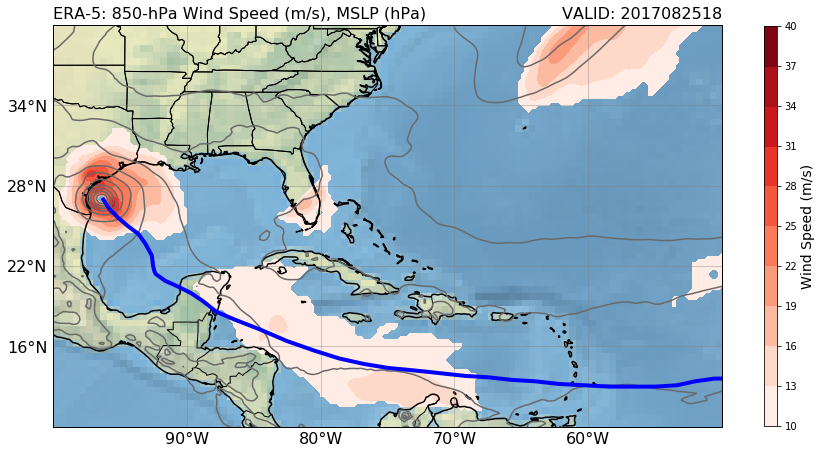

In [13]:
def plot_2D(bt_time_slc, nc_time_slc):
    valid_time = str(dt_list_hr[bt_time_slc])
    wind_speed_2D = np.ma.masked_where(wind_speed<10, wind_speed) 
    ws_ticks = np.linspace(10,40,11)
    p_ticks = np.arange(970, 1020, 3)
    #print(p_ticks)

    #Plotting
    fig, ax = static_gulf_background()
    layer1 = ax.contourf(nclon, nclat, np.squeeze(wind_speed_2D[nc_time_slc,lev_i,:,:]), ws_ticks, 
                         cmap = matplotlib.cm.get_cmap('Reds'),linestyles='solid', transform=ccrs.PlateCarree())

    cont = ax.contour(nclon, nclat, np.squeeze(sfc_pres[nc_time_slc,:,:]/100),p_ticks, colors = 'dimgrey')
    #Background invest best-track
    ax.plot(bt_lon_hr[0:bt_time_slc], bt_lat_hr[0:bt_time_slc], 'b', linewidth = 4)

    #Only plot the storm's current location of invest when valid: Must adjust
    #ax.plot(bt_lon_hr[bt_time_slc], bt_lat_hr[bt_time_slc], 'w*', markersize = 14)

    #Plot settings
    ax.set_title('ERA-5: 850-hPa Wind Speed (m/s), MSLP (hPa)', {"fontsize": 16}, loc='left')
    ax.set_title(f'VALID: {valid_time}', {"fontsize": 16}, loc='right')
    #ax.clabel(cont,  fmt = '%1.0f', fontsize = 10, colors = 'k')
    cbar = fig.colorbar(layer1, orientation='vertical', pad=0.05, shrink=.49, aspect=30,extendrect=True, 
                        ticks = ws_ticks)
    cbar.set_label('Wind Speed (m/s)', fontsize = 14)
    return fig, ax, valid_time
fig, ax, valid_time = plot_2D(bt_time_slc, nc_time_slc)


### 2D Animations

Note that one can run a loop through the valid times of the dataset and generate an image for each, saving it in a directory. Once these are saved, the `imageio` package can be used to stitch these together as a gif animation and save the output.

In [14]:
OUTPUT_DIR_2D = '../OUTPUT/3D_Examples/2D_animation/'
file_name_2D = '2D_map_'
file_list_2D = []
for idx_num in np.arange(0,len(storm_dates_hr)-1):
    #Make image plot
    bt_time_slc_temp = nctime_dates_hr[idx_num]
    nc_time_slc_temp = storm_dates_hr[idx_num]
    fig, ax, valid_time = plot_2D(bt_time_slc_temp, nc_time_slc_temp)
    
    #Save output
    temp_file = OUTPUT_DIR_2D+file_name_2D+valid_time+'.png'
    file_list_2D.append(temp_file)
    fig.savefig(temp_file)
    plt.close()

#### Generate Animation (using Imageio)

If you do not want to override an existing animation, don't run the box right below this!

In [15]:
# import imageio
# with imageio.get_writer('harvey_2D_plot.gif', mode='I', duration = 0.15) as writer:
#     for filename in file_list_2D:
#         image = imageio.imread(filename)
#         writer.append_data(image)

![URLLink](https://github.com/qlawton/images/blob/master/harvey_2D_plot.gif?raw=true "2D Animation of Hurricane Harvey")

## 3D Volume Explorer Widgets with Plot.ly
These are interactive plots I adapted to show cross sections through vertical and horizontal slices of the storm. While *right now* the slices are contained along the x or y directions, it would not be difficult to tilt this slice in any direction (even diagonally across the x and y axes). One would just need a function that built cross-sections from two end points. **I did not have time to do it here, but will in a future update.**

*These interactive widgets are inspired by many python visualizations in the medical field to display MRI and CT images.**

### Horizontal Cross Sections

In [16]:
from skimage import io

volume = wind_data_slice
r, c = volume[0].shape
color_map = 'Rainbow'
tm_stamp = str(dt_list_hr[bt_time_slc])
title_final = 'ERA5: Cross Sections through Hurricane Harvey: '+tm_stamp

camera1 = dict(
    up=dict(x=0, y=0., z=1),
    eye=dict(x=1.25, y=-1.25, z=1.25))

# Define frames
import plotly.graph_objects as go
nb_frames = 25
nb_start = nb_frames-1
nb_pos = nb_start/10
cmi = 0
cma = 35

fig = go.Figure(frames=[go.Frame(data=go.Surface(
    #z=(nb_pos - k * 0.1) * np.ones((r, c)),
    x = lon_new,
    y = lat_new,
    z=lev_new[k]*np.ones((r,c)),
    surfacecolor=volume[k],
    cmin=cmi, cmax=cma
    ),
    name=str(lev_new[k]) # you need to name the frame for the animation to behave properly
    )
    for k in range(len(lev_new))])

# Add data to be displayed before animation starts
fig.add_trace(go.Surface(
    x= lon_new,
    y = lat_new,
    z=lev_new[0] * np.ones((r, c)),
    #z = lev_new,
    surfacecolor=volume[0,:,:],
    colorscale=color_map,
    cmin=cmi, cmax=cma,
    colorbar=dict(thickness=20, ticklen=4, title = 'Wind Speed (m/s)')
    ))


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(lev_new[k]),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Layout
fig.update_layout(scene_camera = camera1,
         title=title_final,
         width=600,
         height=600,
         scene=dict(
                    #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                    xaxis_title='Longitude',
                    yaxis_title='Latitude',
                    zaxis_title='Pressure (mb)',
                    xaxis = dict(range=[lon_new[0], lon_new[-1]], autorange = False), 
                    yaxis = dict(range=[lat_new[-1], lat_new[0]], autorange = False), 
                    zaxis = dict(range=[lev_new[-1], lev_new[0]], autorange = False),
                     aspectratio=dict(x=1, y=1, z=1),
                    ),
            
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()
#fig.write_html('../PLOTLY/Horizontal_section_Harvey.html')

### Vertical Cross Sections

In [17]:
from skimage import io

volume = wind_data_slice
r, c = volume[:,:,0].shape
color_map = 'Rainbow'
tm_stamp = str(dt_list_hr[bt_time_slc])
title_final = 'ERA5: Vertical Cross Sections through Harvey: '+tm_stamp

camera = dict(
    up=dict(x=0, y=1., z=0),
    eye=dict(x=-1.25, y=1.25, z=-2))

# Define frames
import plotly.graph_objects as go
nb_frames = 25
nb_start = nb_frames-1
nb_pos = nb_start/10
cmi = 0
cma = 35

fig2 = go.Figure(frames=[go.Frame(data=go.Surface(
    x = lat_new,
    y = lev_new,
    z=lon_new[k]*np.ones((r,c)),
    surfacecolor=volume[:,:,k],
    cmin=cmi, cmax=cma
    ),
    name=str(lon_new[k]) # you need to name the frame for the animation to behave properly
    )
    for k in range(len(lon_new))])

# Add data to be displayed before animation starts
fig2.add_trace(go.Surface(
    x= lat_new,
    y = lev_new,
    z=lon_new[0]*np.ones((r,c)),
    #z = lev_new,
    surfacecolor=volume[:,:,0],
    colorscale=color_map,
    cmin=cmi, cmax=cma,
    colorbar=dict(thickness=20, ticklen=4, title = 'Wind Speed (m/s)')
    ))


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(lon_new[k]),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig2.frames)
                ],
            }
        ]

# Layout
fig2.update_layout(scene_camera = camera,
         title=title_final,
         width=600,
         height=600,
         scene=dict(
                    #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                    xaxis_title='Latitude',
                    yaxis_title='Pressure (mb)',
                    zaxis_title='Longitude',
                    xaxis = dict(range=[lat_new[-1], lat_new[0]], autorange = False), 
                    yaxis = dict(range=[lev_new[-1], lev_new[0]], autorange = False), 
                    zaxis = dict(range=[lon_new[0], lon_new[-1]], autorange = False),
                     aspectratio=dict(x=1, y=1, z=1),
                    ),
            
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig2.show()
#fig2.write_html('../PLOTLY/Cross_section_Harvey.html')

## Other 3D Visualizations

#### Surface Pressure 3D Surface
Instead of just plotting contours of surface pressure, we can create a unique visualization of the surface pressure as a sort of "height". This plot is interactive as well, like the previous ones.

In [18]:
camera_pres = dict(
    up=dict(x=0, y=0., z=1),
    eye=dict(x=-1.9, y=-1.9, z=.50))
tm_stamp = str(dt_list_hr[bt_time_slc])
title_final = 'Hurricane Harvey Surface Pressure: '+tm_stamp
pmin = 980
pmax = 1010

fig = go.Figure(data=[go.Surface(z=sfc_pres_slice/100, x=lon_new, y=lat_new, 
                                 colorbar=dict(thickness=20, ticklen=4, title = 'Pressure (hPa)'),
                                cmin=pmin, cmax=pmax)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(scene_camera = camera_pres,
         title=title_final,
         width=600,
         height=600,
         scene=dict(
                    #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                    xaxis_title='Longitude',
                    yaxis_title='Latitude',
                    zaxis_title='Pressure (mb)',
                    zaxis = dict(range=[980, 1020], autorange = False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
                 )

fig.show()

### Total Rainfall (1-hour) 3D Surface
Same as above, but now utilizing total precipitation data centered on the storm.

In [19]:
camera_pres = dict(
    up=dict(x=0, y=0., z=1),
    eye=dict(x=-2, y=-1.8, z=1))
tm_stamp = str(dt_list_hr[bt_time_slc])
title_final = 'Hurricane Harvey Precipitation: '+tm_stamp
#pmin = 980
#pmax = 1010

fig = go.Figure(data=[go.Surface(z=total_precip_slice*1000, x=lon_new, y=lat_new, 
                                 colorbar=dict(thickness=20, ticklen=4, title = 'Precip (mm/hr)'))])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(scene_camera = camera_pres,
         title=title_final,
         width=600,
         height=600,
         scene=dict(
                    #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                    xaxis_title='Longitude',
                    yaxis_title='Latitude',
                    zaxis_title='Precipitation (mm/hr)',
                    #zaxis = dict(range=[980, 1020], autorange = False),
                    aspectratio=dict(x=1, y=1, z=1)
                    ),
                 )

fig.show()

### Surface Pressure 3D Surface Animation
Here we create a loop to create and save images of the 3D datasets from above, and in the end stitch it together to create an animation. There are a lot of options that can be changed, from the initial camera angle to the exact extent of the data on the plots. 

Feel free to modify and make your own. Apologies for minimal commenting.

In [20]:
OUTPUT_DIR_PRES = '../OUTPUT/3D_Examples/Sfc_Pres/'
OUTPUT_DIR_PRECIP = '../OUTPUT/3D_Examples/Precip/'
#GIF_DIR = OUTPUT_DIR
file_name_pres = 'sfc_pres_'
file_list_pres = [] #List of output files to make animating easier
file_name_precip = 'precip_'
file_list_precip = []
pmin = 980
pmax = 1010
for idx_num in np.arange(0,len(storm_dates_hr)-1):
    tm_stamp = str(dt_list_hr[bt_time_slc])
    title_final = 'Hurricane Harvey Precipitation: '+tm_stamp
    bt_time_slc = nctime_dates_hr[idx_num]
    nc_time_slc = storm_dates_hr[idx_num]
    sl_nc_time_slc = nc_time_slc #Since both NC files have same nctime, use the same index to slice out each

    #use the last bt_lat, bt_lon as the "genesis point"
    lati, latval = find_nearest(nclat, bt_lat_hr[bt_time_slc])
    loni, lonval = find_nearest(nclon, bt_lon_hr[bt_time_slc])
    lat_slice = slice(int(lati-box_num),int(lati+box_num))
    lon_slice = slice(int(loni-box_num),int(loni+box_num))
    lev_slice = slice(lev_250, lev_1000)
    lon_new_loop = nclon[lon_slice]
    lat_new_loop = nclat[lat_slice]
    lev_new_loop = levels[lev_slice]

    total_precip_slice = np.squeeze(precip[nc_time_slc, lat_slice, lon_slice])
    sfc_pres_slice = np.squeeze(sfc_pres[nc_time_slc, lat_slice, lon_slice])
    
    camera_pres = dict(
        up=dict(x=0, y=0., z=1),
        eye=dict(x=-1.9, y=-1.9, z=.50))
    
    camera_precip = dict(
    up=dict(x=0, y=0., z=1),
    eye=dict(x=-2, y=-1.8, z=1))
    
    # Surface Pressure
    fig = go.Figure(data=[go.Surface(z=sfc_pres_slice/100, x=lon_new_loop, y=lat_new_loop, 
                                     colorbar=dict(thickness=20, ticklen=4, title = 'Pressure (hPa)'),
                                     cmin=pmin, cmax=pmax)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig.update_layout(scene_camera = camera_pres,
             title=title_final,
             width=600,
             height=600,
             scene=dict(
                        #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                        xaxis_title='Longitude',
                        yaxis_title='Latitude',
                        zaxis_title='Pressure (mb)',
                        zaxis = dict(range=[pmin, pmax], autorange = False),
                        aspectratio=dict(x=1, y=1, z=1),
                        ),
                     )
    # Precipitation
    title_final = 'Hurricane Harvey Surface Pressure: '+tm_stamp
    prec_min = 0
    prec_max = 20

    fig2 = go.Figure(data=[go.Surface(z=total_precip_slice*1000, x=lon_new_loop, y=lat_new_loop, 
                                     colorbar=dict(thickness=20, ticklen=4, title = 'Precip (mm/hr)'),
                                     cmin=prec_min, cmax=prec_max)])
    fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig2.update_layout(scene_camera = camera_precip,
             title=title_final,
             width=600,
             height=600,
             scene=dict(
                        #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                        xaxis_title='Longitude',
                        yaxis_title='Latitude',
                        zaxis_title='Precipitation (mm/hr)',
                        zaxis = dict(range=[prec_min, prec_max], autorange = False),
                        aspectratio=dict(x=1, y=1, z=1)
                        ),
                     )

    
    outfile_pres = OUTPUT_DIR_PRES+file_name_pres+tm_stamp+'.png'
    outfile_precip = OUTPUT_DIR_PRECIP+file_name_precip+tm_stamp+'.png'
    file_list_pres.append(outfile_pres)
    file_list_precip.append(outfile_precip)
    fig.write_image(outfile_pres)
    fig2.write_image(outfile_precip)
#fig.show()    

#### Generate Animation
The following lines of code will stitch together everything into an animation. Don't run this cell if you don't want to overwrite the existing file.

In [21]:
# import imageio
# with imageio.get_writer('sfc_pres_3D_update.gif', mode='I', duration = 0.1) as writer:
#     for filename in file_list_pres:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# with imageio.get_writer('sfc_precip_3D_update3.gif', mode='I', duration = 0.2) as writer:
#     for filename in file_list_precip:
#         image = imageio.imread(filename)
#         writer.append_data(image)


![SegmentLocal](https://github.com/qlawton/images/blob/master/sfc_pres_3D_update.gif?raw=true "Harvey 3D Pressure Surface")

![SegmentLocal](https://github.com/qlawton/images/blob/master/sfc_precip_3D_update3.gif?raw=true "Harvey 3D Precip")

#### Making a 3D Mesh Plot 
Now we will make a 3D mesh plot, in this case of the wind speed contours to get a sense of the wind structure. For these purposes, I will use 18 m/s as a cutoff threshold simply because it is the cutoff for tropical storm force wind.

In [22]:
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans

from plotly import figure_factory as FF

# IMPORTANT ------------------ SETTINGS -------------------------------------------
thresh_mesh = 18 #m/s
title_mesh = '3D Mesh of Hurricane Harvey '+str(thresh_mesh)+' m/s Surface: '+tm_stamp

camera_mesh = dict(
    up=dict(x=0, y=0., z=-1),
    eye=dict(x=-1.25, y=-1.25, z=2))

### ------------------- SOME DATA MANIPULATION ------------------------------------
#Importantly, I must make my data equally spaced throughout the vertical direction. So will remove certain axes.
lev_diff = np.diff(lev_new)
lev_diff_sfc = np.diff(lev_new)[0]
diff_list = []
for st_idx, st_val in enumerate(lev_diff):
    if st_val != lev_diff_sfc:
        diff_list.append(st_idx)
        
diff_list = diff_list[1::2] #These are the indices to remove
slice_diff = []
for idx, val in enumerate(lev_new[:-1]):
    if idx not in diff_list:
        slice_diff.append(idx)

#Now, slice out the corerct data    
lev_new_edit = lev_new[slice_diff]
wind_data_slice_edit = wind_data_slice[slice_diff,:,:]

### -------------------------------------------------------------------------------
# PLOTTING
wind_data_edit = wind_data_slice_edit.transpose(2,1,0)
verts, faces, norm, val = measure.marching_cubes_lewiner(wind_data_edit, thresh_mesh)

# CREATE MESHGRID OF COORDINATES
X, Y, Z = np.meshgrid(lon_new, lat_new, lev_new_edit, indexing = 'xy')

X = X.flatten()
Y = Y.flatten()
Z = Z.flatten()

verts *= np.array([np.diff(ar)[0] for ar in [lon_new,lat_new,lev_new_edit]])
verts[:,0] += np.array([np.min(X)])
verts[:,1] += np.array([np.max(Y)])
verts[:,2] += np.array([np.min(Z)])
x,y,z = zip(*verts)

#CREATE FIGURE AND PLOT
fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=True,
                        simplices=faces)
#MAKE AESTHETIC CHANGES TO PLOT
fig.update_layout(scene_camera = camera_mesh,
         title=title_mesh,
         width=600,
         height=600,
         scene=dict(
                    #zaxis=dict(range=[-0.1, nb_pos], autorange=False),
                    xaxis_title='Longitude',
                    yaxis_title='Latitude',
                    zaxis_title='Pressure (mb)',
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
                 )
fig.show()

# SAVE INTERACTIVE PLOT
fig.write_html('../PLOTLY/Mesh_3D_Wind_Speed.html')


### Volume Plots
Have not been able to manipulate data in a way to make this feasible for the more messy atmospheric data yet. This is because the interpolation used by the plotly code to sketch the volume contours does not handle the noise/smoothing of these datasets well. If one was able to separately smooth/modify data, it would make volume plots possible.

In [24]:
#wind_data_slice = np.swapaxes(wind_data_slice, 0, -1)
X, Y, Z = np.meshgrid(lon_new, lat_new, lev_new, indexing = 'xy')
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=wind_data_slice.flatten(),
    opacity = 0.1# needs to be a large number for good volume rendering
    ))
fig.show()

# fig = go.Figure(data=go.Volume(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=Z.flatten(),
#     value=smoothed.flatten(),
#     isomin=10,
#     isomax=40,
#     caps=dict(x_show=False, y_show=False)
#     ))
# fig.show()